In [1]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
import gensim
import pyLDAvis.gensim
import numpy as np
import logging
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import time
from pprint import pprint

In [2]:
data = pd.read_csv("./modi_data/kor_full.csv") ############
#data = data.drop(data.index[50:]) ###################### decrease size
#data = data.drop(['Unnamed: 0'], axis=1)
print(data)

       no  year                                           kor_full
0     137  2002  탐색 알고리즘 교육을 위한 S/W 컴포넌트의 개발 탐색알고리즘교육, 컴퓨터프로그래밍...
1     147  2002  프로젝트 학습을 기반으로 하는 ICT 활용 수업 모형의 개발 및 적용 ICT 활용교...
2     148  2002  분산 컴퓨팅 환경에서의 웹 교육 컴포넌트 개발과정 모델링 웹기반 교육, 컴포넌트 개...
3     149  2002  효과적인 아동용 WBI를 위한 한글 타이포그래피의 가해성 분석과 활용 타이포 그래피...
4     150  2002  교수 · 학습 디지털 컨텐트 통합메타데이터 및 개체-관계 모델 설계 교수.학습, 컨...
..    ...   ...                                                ...
807  1121  2020  R 매핑을 이용한 인공지능의 교육적 활용 탐색 - 국외 문헌 분석을 중심으로 - 인...
808  1122  2020  중학교 정보교과에서 짝 프로그래밍이 4Cs 향상에 미치는 영향 짝 프로그래밍, 4C...
809  1123  2020  자동 분류 기술을 활용한 온라인 강의 평가 방법 빅 데이터 분석, 온라인 강의 평가...
810  1124  2020  인공지능교육 역량 강화를 위한 교원 연수 프로그램과 교사 요구분석 인공지능교육, 교...
811  1125  2020  초·중등 현직 교원의 스크래치 활용 교수자료 개발에 대한 경험 분석 : ASSURE...

[812 rows x 3 columns]


In [3]:
dfWordList = pd.read_excel("./word_cor.xlsx")
#print(dfWordList)

dfWordDel = dfWordList[dfWordList["수정"] == "삭제"]
dfWordMod = dfWordList[dfWordList["수정"] != "삭제"]
#print(dfWordMod)

seriesDelete = dfWordDel["원본"]
stopword = []
for word in seriesDelete.values:
    stopword.append(word)
#print(listDelete)

seriesModify = dfWordMod["원본"]
modiword = []
for word in seriesModify.values:
    modiword.append(word)
#print(len(modiword))

seriesModify2 = dfWordMod["수정"]
modiword2 = []
for word in seriesModify2.values:
    modiword2.append(word)
#print(len(modiword2))

C:\Users\uni61\anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\uni61\anaconda3\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\uni61\anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [4]:
okt = Okt()
def oktTokenizer(raw, stopword=stopword, pos=['Noun', 'Alpha']):
    list = []
    for word, tag in okt.pos(raw, #raw data
                                 norm=True, #normalize
                                 stem=True #stemming
                                 ):
        if len(word) > 1 and tag in pos and word not in stopword: 
            if tag == 'Alpha':
                word = word.lower()
            if word in modiword:
                word = modiword2[modiword.index(word)]
            list.append(word)        
    return list

In [5]:
tokenized = data["kor_full"].apply(lambda row: oktTokenizer(row))
#print(tokenized)
tokenized.to_excel("./final_data/1123token_full.xls") ##############
print("========= tokenization completed =========")

========= tokenization completed =========


In [6]:
#lda
id2word = gensim.corpora.Dictionary(tokenized)

wordlist = []
for i in range(len(id2word)):
    #print(id2word[i])
    wordlist.append(id2word[i])
#print(wordlist)
seriesWordlist = pd.Series(wordlist)
seriesWordlist.to_excel("./final_data/1123wordlist_full.xls") #################

corpus=[id2word.doc2bow(text) for text in tokenized]
#print("id2word for each document : ", corpus)
print("# words in total : ", len(id2word))
print("# documents : ", len(corpus))

# words in total :  3854
# documents :  812


In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_list.append(model)
        perplexitymodel = model.log_perplexity(corpus)
        perplexity_values.append(perplexitymodel)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, perplexity_values, coherence_values

In [8]:
#start = time.time()
model_list, perplexity_values, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=tokenized,
                                                        start=2,
                                                        limit=31, #####
                                                        step=1)
#print("time : ", ( time.time() - start )/60, "min")

2
3
4
5
6
7
8
9
10
11
12


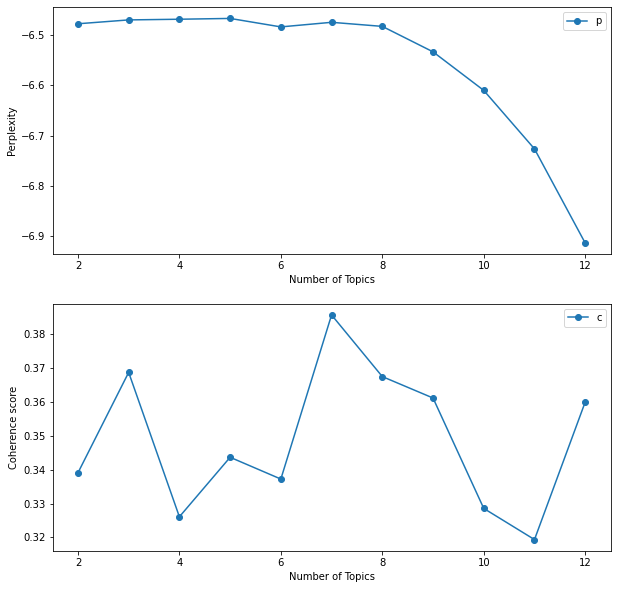

In [10]:
limit=31 ######
start=2
step=1
x = range(start, limit, step)


fig, ax = plt.subplots(2,1, figsize=(10, 10))

ax[0].plot(x, perplexity_values, marker='o')
ax[0].set_xlabel("Number of Topics")
ax[0].set_ylabel("Perplexity")
ax[0].legend(("perplexity"), loc='best')

ax[1].plot(x, coherence_values, marker='o')
ax[1].set_xlabel("Number of Topics")
ax[1].set_ylabel("Coherence score")
ax[1].legend(("coherence_values"), loc='best')
plt.show()

In [11]:
for m, pv in zip(x, perplexity_values):
  print("Num Topics =", m, " has Perplexity Value of", round(pv, 4))

for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Perplexity Value of -6.4773
Num Topics = 3  has Perplexity Value of -6.4697
Num Topics = 4  has Perplexity Value of -6.4683
Num Topics = 5  has Perplexity Value of -6.4667
Num Topics = 6  has Perplexity Value of -6.4836
Num Topics = 7  has Perplexity Value of -6.4744
Num Topics = 8  has Perplexity Value of -6.4825
Num Topics = 9  has Perplexity Value of -6.5331
Num Topics = 10  has Perplexity Value of -6.6098
Num Topics = 11  has Perplexity Value of -6.7261
Num Topics = 12  has Perplexity Value of -6.9133
Num Topics = 2  has Coherence Value of 0.339
Num Topics = 3  has Coherence Value of 0.3687
Num Topics = 4  has Coherence Value of 0.3261
Num Topics = 5  has Coherence Value of 0.3436
Num Topics = 6  has Coherence Value of 0.3372
Num Topics = 7  has Coherence Value of 0.3856
Num Topics = 8  has Coherence Value of 0.3675
Num Topics = 9  has Coherence Value of 0.3611
Num Topics = 10  has Coherence Value of 0.3286
Num Topics = 11  has Coherence Value of 0.3194
Num Topi

In [12]:
a = int(input("set the number of topics "))
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=a,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

set the number of topics  7


[(0,
  '0.104*"교육" + 0.045*"인공지능" + 0.037*"교육과정" + 0.029*"내용" + 0.025*"컴퓨터" + '
  '0.024*"정보" + 0.017*"연구" + 0.014*"모델" + 0.014*"초등학교" + 0.013*"제시" + '
  '0.012*"영역" + 0.012*"체계" + 0.011*"리터러시" + 0.011*"초등" + 0.010*"활동" + '
  '0.010*"cs" + 0.010*"교과" + 0.010*"과학" + 0.010*"디지털" + 0.010*"기준" + '
  '0.009*"언플러그드" + 0.009*"자료" + 0.008*"교과서" + 0.008*"개정" + 0.008*"구성" + '
  '0.008*"개발" + 0.008*"창의성" + 0.008*"제작" + 0.007*"방법" + 0.007*"컴퓨터과학"'),
 (1,
  '0.042*"스마트" + 0.028*"표준" + 0.027*"스마트폰" + 0.024*"콘텐츠" + 0.022*"교육" + '
  '0.019*"활용" + 0.018*"ict" + 0.017*"사용" + 0.016*"개발" + 0.016*"정책" + '
  '0.015*"소속" + 0.013*"국내외" + 0.012*"항목" + 0.011*"관리" + 0.009*"이용" + '
  '0.009*"학생" + 0.009*"sns" + 0.009*"동영상" + 0.008*"논문" + 0.008*"환경" + '
  '0.008*"도구" + 0.008*"제작" + 0.008*"모델" + 0.008*"pisa" + 0.007*"정규" + '
  '0.007*"가정" + 0.007*"실행" + 0.007*"아동" + 0.007*"지역" + 0.007*"기획"'),
 (2,
  '0.077*"학습" + 0.027*"수업" + 0.022*"교수" + 0.022*"학습자" + 0.021*"연구" + '
  '0.019*"모형" + 0.018*"활용" + 0.018*"적용" + 0.015*

In [13]:
title = input("set the title of html file ")
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, title+".html")

set the title of html file  test


In [24]:
# 문서별 토픽 비율
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        #print(doc)
        #print(topic_list)
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [25]:
topictable = make_topictable_per_doc(optimal_model, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
print(topictable)

     문서 번호  가장 비중이 높은 토픽  가장 높은 토픽의 비중  \
0        0           4.0        0.8565   
1        1           2.0        0.6811   
2        2           4.0        0.6127   
3        3           0.0        0.5314   
4        4           2.0        0.4584   
..     ...           ...           ...   
807    807           0.0        0.3562   
808    808           4.0        0.4678   
809    809           2.0        0.3784   
810    810           6.0        0.3112   
811    811           2.0        0.5211   

                                              각 토픽의 비중  
0    ([(0, 0.07037959), (2, 0.02408798), (4, 0.8565...  
1    ([(0, 0.06928534), (2, 0.68108), (3, 0.0119127...  
2    ([(0, 0.01445057), (1, 0.1458663), (2, 0.12372...  
3    ([(0, 0.531351), (1, 0.14915271), (2, 0.168336...  
4    ([(0, 0.10114034), (1, 0.14024757), (2, 0.4584...  
..                                                 ...  
807  ([(0, 0.3561542), (2, 0.066981256), (3, 0.0110...  
808  ([(0, 0.1578849), (2, 0.17277624),

In [17]:
topictable.to_excel("./final_data/1123doc2topic.xls")